<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch6-TD_Learning/Ch6_OffPolicyTDLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
np.random.seed(0)

## Cliff Walking
This is an example of the markov random process Example 6.6 in page-132 from the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).



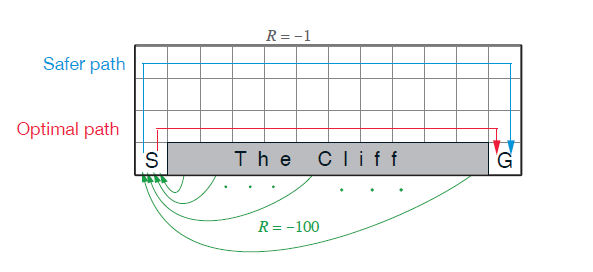

In [2]:
grid_rows = 4
grid_cols = 12
hv_actions = [[-1,0],[0,1],[1,0],[0,-1]]
start = [3,0]
goal = [3,11]

In [3]:
def getReward(pos):
  if pos[0] == 3 and pos[1] in range(1,11):
    return -100
  return -1

def target_policy(Q,actions,pos,epsilon):
  nA = len(actions)
  idx = np.arange(nA)
  action_prob = epsilon/float(nA)*np.ones((nA,))

  maxQ = np.max(Q[pos[0],pos[1],idx])
  best_actions = idx[np.where(Q[pos[0],pos[1],idx] == maxQ)[0]]
  action_prob[best_actions] += (1-epsilon)/float(len(best_actions))

  choice = np.random.choice(idx,p=action_prob)
  return choice

def step(pos,action):
  next_state = [max(0,min(grid_rows-1,pos[0]+action[0])),max(0,min(grid_cols-1,pos[1]+action[1]))]
  reward = getReward(next_state)
  if reward == -100:
    return start,reward
  return next_state,reward

def play_back(Q,actions):
  pos = start
  traj = []
  while pos[0] != goal[0] or pos[1] != goal[1]:
    traj += [pos]
    act_idx = target_policy(Q,actions,pos,0)
    next_pos,_ = step(pos,actions[act_idx])
    pos = next_pos
  return traj

def SARSA(num_episodes,actions,alpha,epsilon,gamma):
  Q = np.zeros((grid_rows,grid_cols,len(actions)))

  stats = []
  for episode in range(num_episodes):#tqdm(range(num_episodes)):
    pos = start
    act_idx = target_policy(Q,actions,pos,epsilon)
    steps = 0
    rewards = 0
    while pos[0] != goal[0] or pos[1] != goal[1]:
      next_pos,reward = step(pos,actions[act_idx])
      steps += reward
      next_act_idx = target_policy(Q,actions,next_pos,epsilon)
      Q[pos[0],pos[1],act_idx] += alpha*(reward + gamma*Q[next_pos[0],next_pos[1],next_act_idx] - Q[pos[0],pos[1],act_idx])
      pos = next_pos
      act_idx = next_act_idx

    stats += [[episode+1,steps]]
  return Q,np.array(stats)

def QLearning(num_episodes,actions,alpha,epsilon,gamma):
  Q = np.zeros((grid_rows,grid_cols,len(actions)))

  stats = []
  for episode in range(num_episodes):#tqdm(range(num_episodes)):
    pos = start
    steps = 0
    rewards = 0
    while pos[0] != goal[0] or pos[1] != goal[1]:
      act_idx = target_policy(Q,actions,pos,epsilon)
      next_pos,reward = step(pos,actions[act_idx])
      steps += reward
      Q[pos[0],pos[1],act_idx] += alpha*(reward + gamma*np.max(Q[next_pos[0],next_pos[1],:]) - Q[pos[0],pos[1],act_idx])
      pos = next_pos

    stats += [[episode+1,steps]]
  return Q,np.array(stats)  

def plot_grid(ax,traj1,traj2):
  # create discrete colormap
  cmap = colors.ListedColormap(['white','magenta','blue','green','red','black'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  map = np.zeros((grid_rows,grid_cols))
  map[start[0],start[1]] = 1
  map[goal[0],goal[1]] = 4
  map[3,1:-1] = 5
  for i,t in enumerate(traj1):
    if i == 0:
      continue
    map[t[0],t[1]] = 2
    for i,t in enumerate(traj2):
      if i == 0:
        continue
      map[t[0],t[1]] = 3
  ax.imshow(map, cmap=cmap)#, norm=norm)
  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, grid_cols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, grid_rows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, grid_cols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, grid_rows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

In [4]:
num_runs = 50
num_episodes = 500
epsilon = 0.1
alpha = 0.5
gamma = 1
sarsa_stats = np.zeros((num_episodes,2))
ql_stats = np.zeros((num_episodes,2))
Q_sarsa = np.zeros((grid_rows,grid_cols,len(hv_actions)))
Q_ql = np.zeros((grid_rows,grid_cols,len(hv_actions)))
for i in tqdm(range(num_runs)):
  Q1,stats_sarsa = SARSA(num_episodes,hv_actions,alpha,epsilon,gamma)
  Q2,stats_ql = QLearning(num_episodes,hv_actions,alpha,epsilon,gamma)
  Q_sarsa += Q1
  Q_ql += Q2
  
  sarsa_stats[:,1] += stats_sarsa[:,1]
  ql_stats[:,1] += stats_ql[:,1]

sarsa_stats[:,0] = stats_sarsa[:,0]
ql_stats[:,0] = stats_ql[:,0]
sarsa_stats[:,1] = sarsa_stats[:,1]/float(num_runs)
ql_stats[:,1] = ql_stats[:,1]/float(num_runs)

Q_sarsa = Q_sarsa/float(num_runs)
Q_ql = Q_ql/float(num_runs)

100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


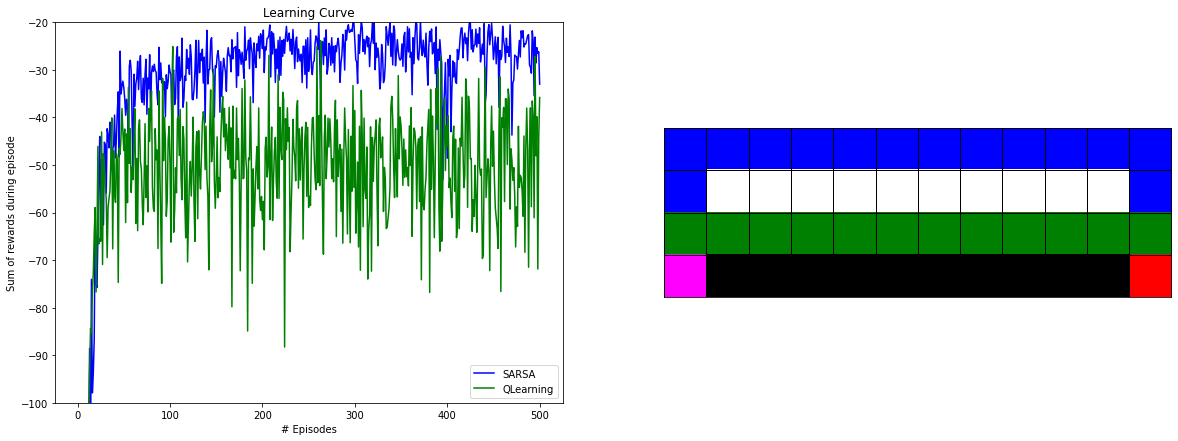

In [5]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(sarsa_stats[:,0],sarsa_stats[:,1],'b')
ax[0].plot(ql_stats[:,0],ql_stats[:,1],'g')
ax[0].set_ylim([-100,-20])
ax[0].set_xlabel('# Episodes');
ax[0].set_ylabel('Sum of rewards during episode');
ax[0].set_title('Learning Curve');
ax[0].legend(['SARSA','QLearning']);

sarsa_traj = play_back(Q_sarsa,hv_actions)
ql_traj = play_back(Q_ql,hv_actions)
plot_grid(ax[1],sarsa_traj,ql_traj)